In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import pcms.tree
import utils
from utils.constants import *

## Compute the exact value of $\mathbb{E}[\mathrm{L}_n]$

### Draw samples of $\mathrm{L}_n$ and compute the sample means

In [18]:
N = 10000
Ns = np.arange(2, N, 50)
n_samples = 50

ln_means = []
for n_leaves in Ns:
    draw = utils.draw_ln(n_samples=n_samples, n_leaves=n_leaves)
    ln_means.append(np.mean(draw))
ln_means = np.array(ln_means)

In [19]:
ln_exacts = []
for n_leaves in Ns:
    ln_exacts.append(utils.exp_ln_exact(n_leaves))
ln_exacts = np.array(ln_exacts)

### First moment

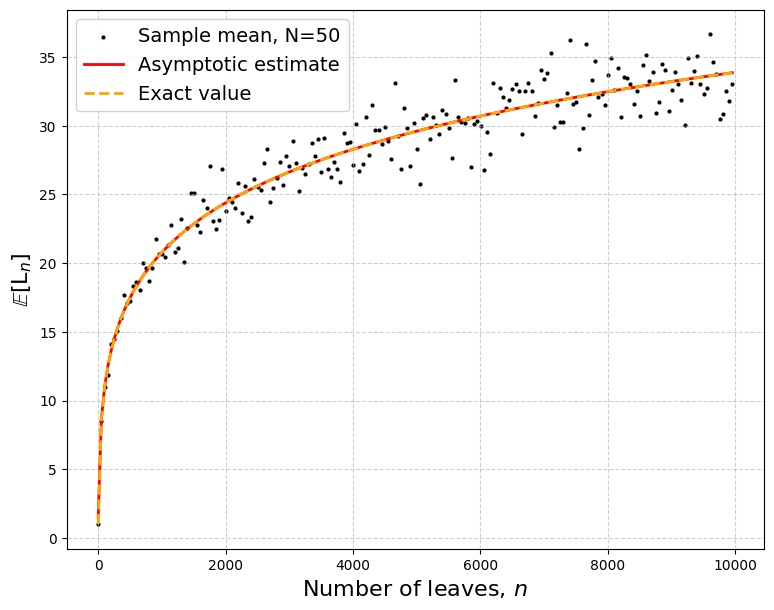

In [20]:
fig, ax = plt.subplots(figsize=(9, 7)) 

ax.scatter(Ns, ln_means, label=f'Sample mean, N={n_samples}', color='black', s=4)
ax.plot(Ns, utils.ELn(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)
ax.plot(Ns, ln_exacts, label='Exact value', linestyle='--', color='orange', linewidth=2)

ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{E}[\mathrm{L}_n]$', fontsize=16)
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

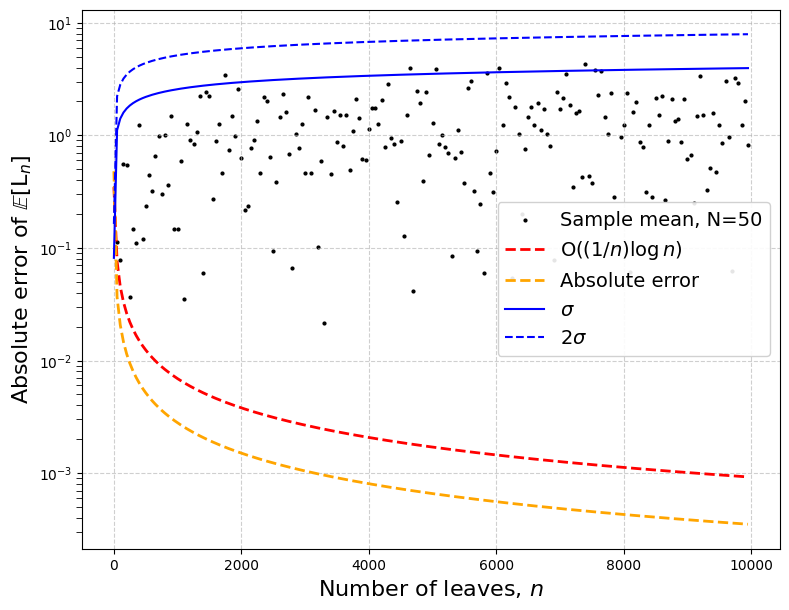

In [21]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(Ns, np.abs(ln_means - ln_exacts), label=f'Sample mean, N={n_samples}', color='black', s=4)
ax.plot(Ns, np.log(Ns)/Ns, label=r'$\mathrm{O}((1/n)\log n)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(ln_exacts - utils.ELn(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)
ax.plot(Ns, np.sqrt(np.log(Ns)**3 / n_samples), label=r'$\sigma$', linestyle='-', color='blue', linewidth=1.5)
ax.plot(Ns, 2 * np.sqrt(np.log(Ns)**3 / n_samples), label=r'$2\sigma$', linestyle='--', color='blue', linewidth=1.5)

ax.set_yscale('log')
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathbb{E}[\mathrm{L}_n]$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

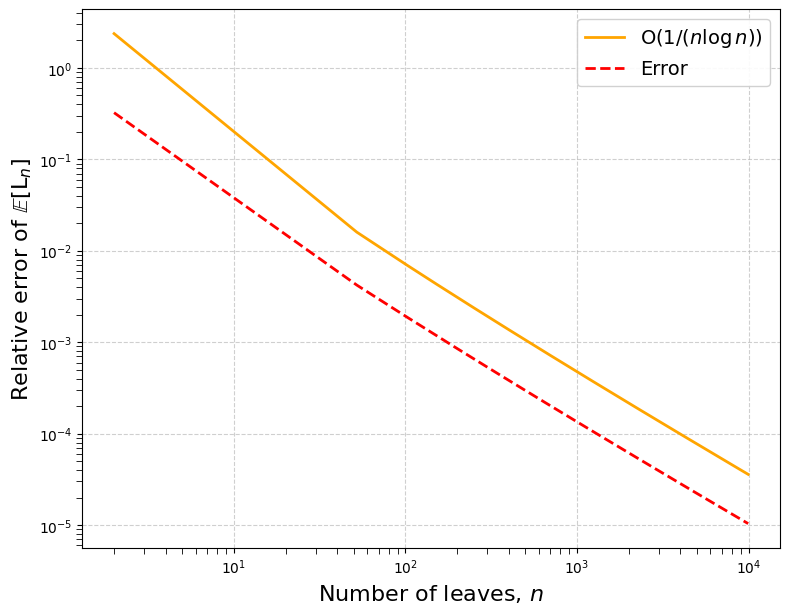

In [12]:
fig, ax = plt.subplots(figsize=(9, 7)) 

ax.plot(Ns, 1/(A0 * Ns * np.log(Ns)), label=r'$\mathrm{O}(1/(n\log n))$', linestyle='-', color='orange', linewidth=2)
ax.plot(Ns, np.abs(ln_exacts - utils.ELn(Ns)) / utils.ELn(Ns), label='Error', linestyle='--', color='red', linewidth=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Relative error of $\mathbb{E}[\mathrm{L}_n]$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

## Asymptotic approximations of the first two moments and variance of $\mathrm{EPL}(\mathrm{T}_n)$

### Draw samples and compute sample moments and variance

In [7]:
N = 10000
Ns = np.arange(2, N, 50)
n_samples = 200
epl_means = []
epl_vars = []
epl_mean2s = []
for n_leaves in Ns:
    draw = utils.draw_epl(n_samples=n_samples, n_leaves=n_leaves)
    epl_means.append(np.mean(draw))
    epl_vars.append(np.var(draw))
    epl_mean2s.append(np.mean(np.pow(draw,2)))

### An asymptotic estimate for the first moment of $\mathrm{EPL}(\mathrm{T}_n)$

In [8]:
epln_exacts = Ns * ln_exacts

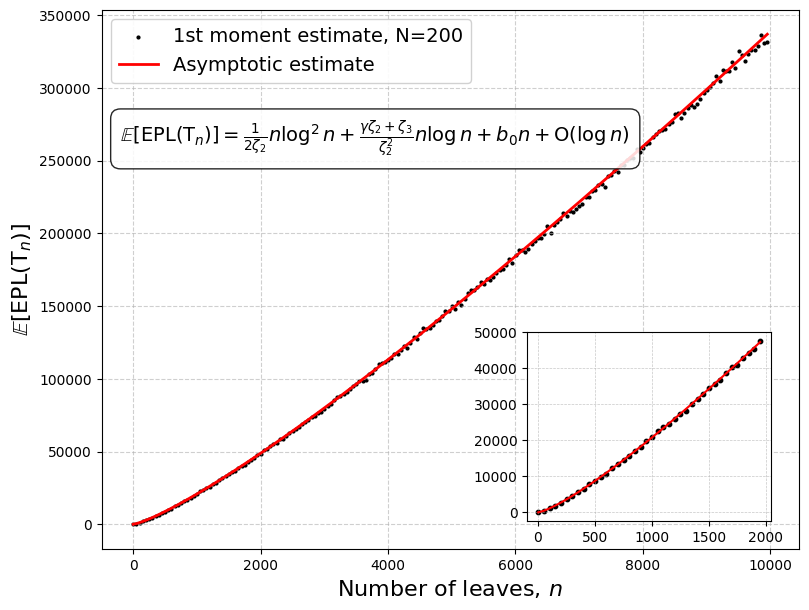

In [9]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(Ns, epl_means, label=f'1st moment estimate, N={n_samples}', color='black', s=4)
ax.plot(Ns, utils.EEPLn(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)

equation_text = (r"$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)] = \frac{1}{2\zeta_2}n\log^2 n + "
                 r"\frac{\gamma\zeta_2+\zeta_3}{\zeta_2^2}n\log n + b_0 n + \mathrm{O}(\log n)$")
ax.text(3800, 2.65e5, equation_text, fontsize=14, va='center', ha='center', 
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.85, boxstyle='round,pad=0.5'))

end = int(2 * len(Ns)/10)
x_padding = 0.02  # Adjust x padding (fraction of the figure width)
y_padding = 0.04  # Adjust y padding (fraction of the figure height)
inset_ax = inset_axes(
    ax,
    width="35%", 
    height="35%",
    loc="lower right",
    borderpad=2
)
inset_ax.scatter(Ns[:end], epl_means[:end], color='black', s=10)
inset_ax.plot(Ns[:end], utils.EEPLn(Ns[:end]), color='red', linewidth=1.5)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)]$', fontsize=16)
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

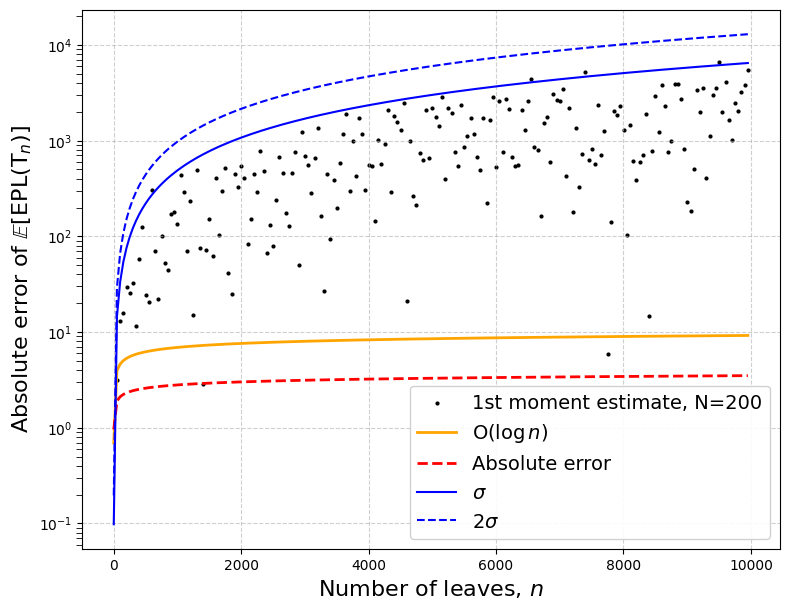

In [16]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(Ns, np.abs(epl_means - epln_exacts), label=f'1st moment estimate, N={n_samples}', color='black', s=4)
ax.plot(Ns, np.log(Ns), label=r'$\mathrm{O}(\log n)$', linestyle='-', color='orange', linewidth=2)
ax.plot(Ns, np.abs(epln_exacts - utils.EEPLn(Ns)), label='Absolute error', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.sqrt(Ns**2 * np.log(Ns)**2 / n_samples), label=r'$\sigma$', linestyle='-', color='blue', linewidth=1.5)
ax.plot(Ns, 2 * np.sqrt(Ns**2 * np.log(Ns)**2 / n_samples), label=r'$2\sigma$', linestyle='--', color='blue', linewidth=1.5)

ax.set_yscale('log')
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)]$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

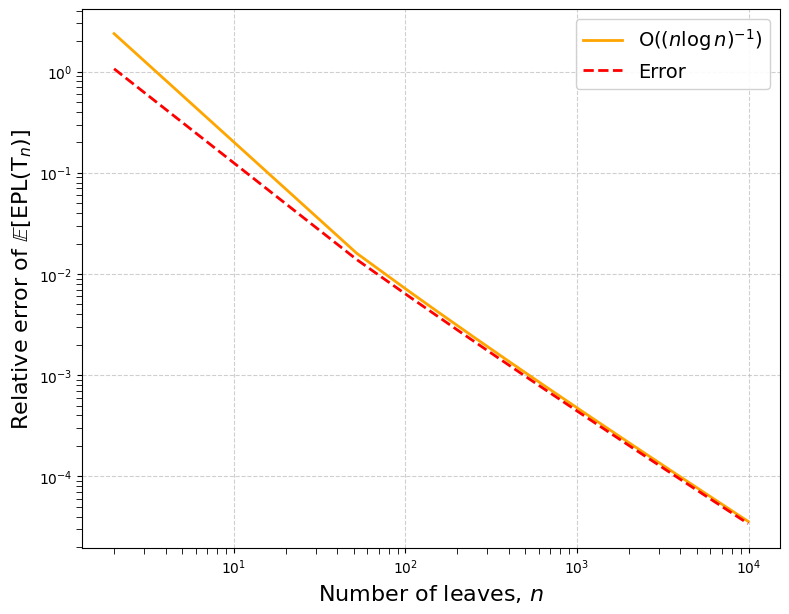

In [27]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(Ns, 1/(A1 * Ns * np.log(Ns)), label=r'$\mathrm{O}((n\log n)^{-1})$', linestyle='-', color='orange', linewidth=2)
ax.plot(Ns, np.abs(epln_exacts - utils.EEPLn(Ns)) / (A1 * utils.EEPLn(Ns)), label='Error', linestyle='--', color='red', linewidth=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Relative error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)]$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

### Compute exact value of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$

In [12]:
epln2_exacts = []
for n_leaves in Ns:
    epln2_exacts.append(utils.exp_epln2_exact(n_leaves))
epln2_exacts = np.array(epln2_exacts)

### Second moment

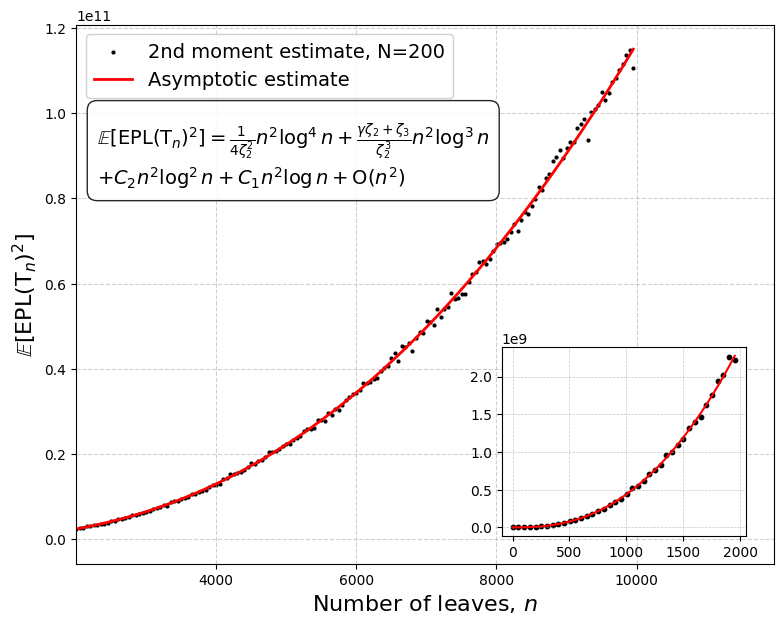

In [13]:
end = int(len(Ns)/5)

fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(Ns, epl_mean2s, label=f'2nd moment estimate, N={n_samples}', color='black', marker='o', s=4)
ax.plot(Ns, utils.EEPLn2(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)

equation_text = (
    r"$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2] = \frac{1}{4\zeta_2^2} n^2 \log^4 n + \frac{\gamma\zeta_2 + \zeta_3}{\zeta_2^3} n^2 \log^3 n $" "\n"
    r"$+ C_2 n^2 \log^2 n + C_1 n^2 \log n + \mathrm{O}(n^2)$"
)
ax.text(
    2300, 0.9e11, equation_text, fontsize=14, va="center", ha="left",
    multialignment="left", 
    bbox=dict(
        facecolor="white", 
        edgecolor="black", 
        alpha=0.85, 
        boxstyle="round,pad=0.5"
    )
)

x_padding = 0.02  # Adjust x padding (fraction of the figure width)
y_padding = 0.04  # Adjust y padding (fraction of the figure height)
inset_ax = inset_axes(
    ax,
    width="35%", 
    height="35%",
    loc="lower right",
    borderpad=2
)
inset_ax.scatter(Ns[:end], epl_mean2s[:end], color='black', s=10)
inset_ax.plot(Ns[:end], utils.EEPLn2(Ns[:end]), color='red', linewidth=1.5)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

ax.set_xlim([Ns[end], Ns[-1] + Ns[end]])
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$', fontsize=16)
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

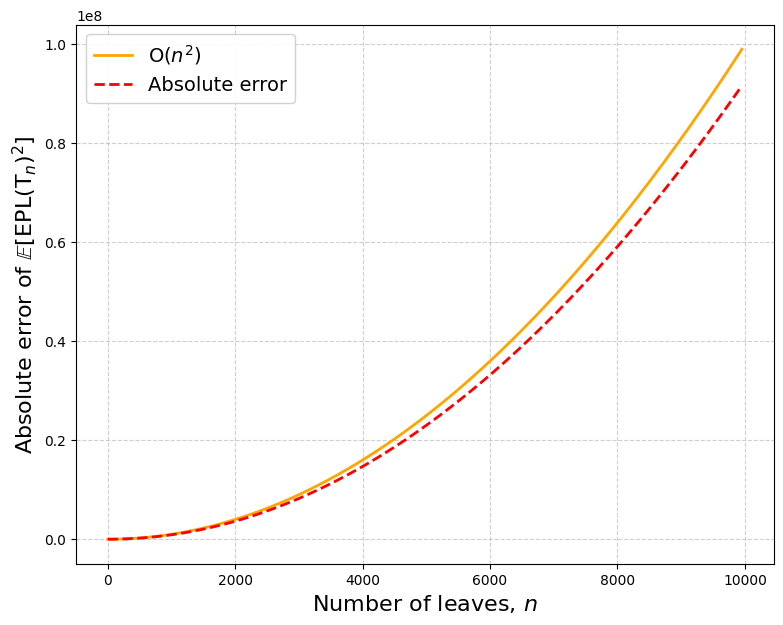

In [22]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(Ns, Ns**2, label=r'$\mathrm{O}(n^2)$', linestyle='-', color='orange', linewidth=2)
ax.plot(Ns, np.abs(epln2_exacts - utils.EEPLn2(Ns)), label='Absolute error', linestyle='--', color='red', linewidth=2)

ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

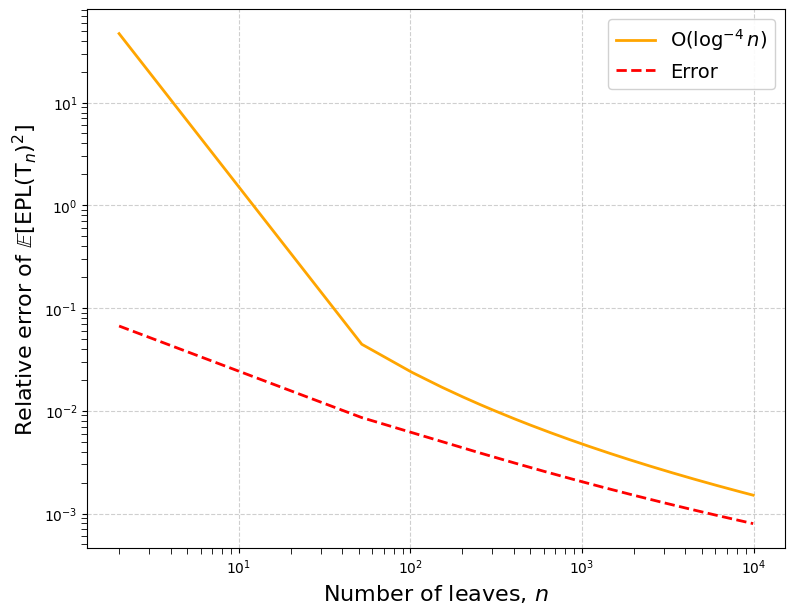

In [23]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(Ns, 1 / (A2 * np.log(Ns)**4), label=r'$\mathrm{O}(\log^{-4} n)$', linestyle='-', color='orange', linewidth=2)
ax.plot(Ns, np.abs(epln2_exacts - utils.EEPLn2(Ns))/utils.EEPLn2(Ns), label='Error', linestyle='--', color='red', linewidth=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Relative error of $\mathbb{E}[\mathrm{EPL}(\mathrm{T}_n)^2]$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

### Variance

In [16]:
var_exacts = epln2_exacts - epln_exacts**2

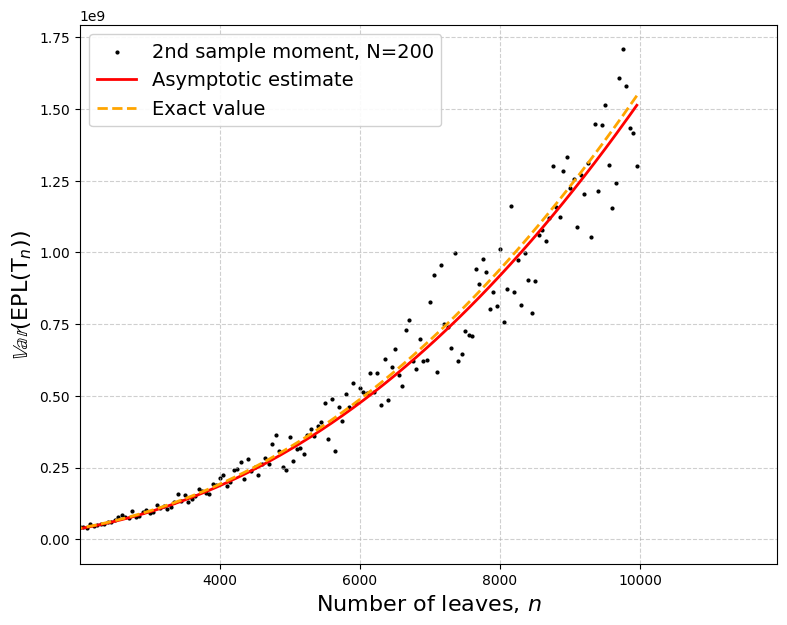

In [17]:
end = int(len(Ns)/5)

fig, ax = plt.subplots(figsize=(9, 7))

ax.scatter(Ns, epl_vars, label=f'2nd sample moment, N={n_samples}', color='black', marker='o', s=4)
ax.plot(Ns, utils.VEPLn(Ns), label='Asymptotic estimate', linestyle='-', color='red', linewidth=2)
ax.plot(Ns, var_exacts, label='Exact value', linestyle='--', color='orange', linewidth=2)

ax.set_xlim([Ns[end], Ns[-1] + Ns[end]])
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'$\mathbb{Var}(\mathrm{EPL}(\mathrm{T}_n))$', fontsize=16)
ax.legend(fontsize=14, loc='upper left', frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

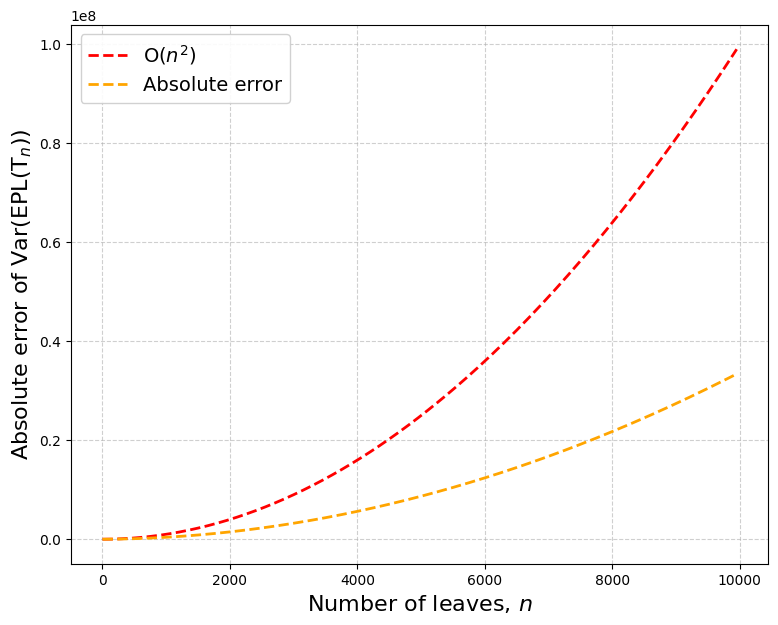

In [18]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(Ns, Ns**2, label=r'$\mathrm{O}(n^2)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(var_exacts - utils.VEPLn(Ns)), label='Absolute error', linestyle='--', color='orange', linewidth=2)

ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathrm{Var}(\mathrm{EPL}(\mathrm{T}_n))$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()

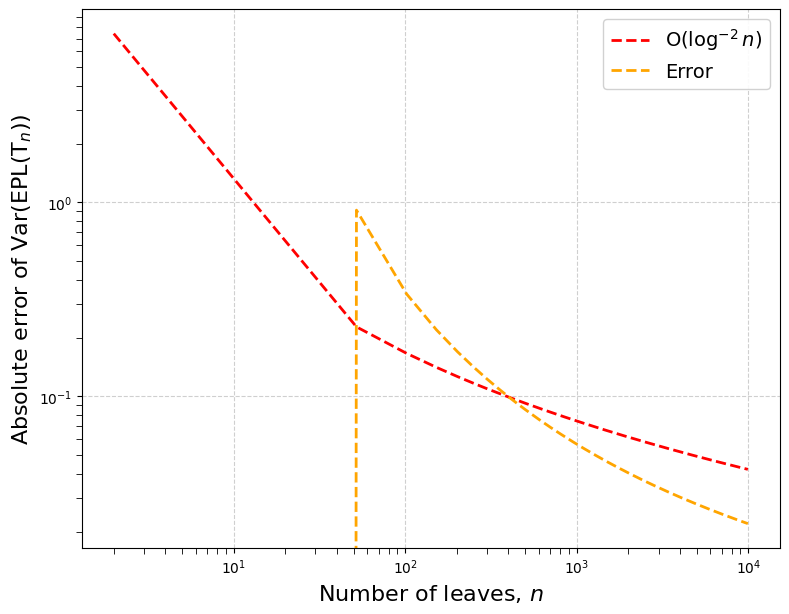

In [19]:
fig, ax = plt.subplots(figsize=(9, 7)) 

ax.plot(Ns, 1 / (A3 * np.log(Ns)**2), label=r'$\mathrm{O}(\log^{-2} n)$', linestyle='--', color='red', linewidth=2)
ax.plot(Ns, np.abs(var_exacts - utils.VEPLn(Ns)) / utils.VEPLn(Ns), label='Error', linestyle='--', color='orange', linewidth=2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'Number of leaves, $n$', fontsize=16)
ax.set_ylabel(r'Absolute error of $\mathrm{Var}(\mathrm{EPL}(\mathrm{T}_n))$', fontsize=16)
ax.legend(fontsize=14, frameon=True, framealpha=0.9)
ax.grid(visible=True, linestyle='--', alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', length=4)

plt.show()